In [2]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

from utils import dataset_INCan
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sklearn
# normalize the features
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
# classifiers
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
# use leave one out cross validation
from sklearn.model_selection import LeaveOneOut
# metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve

We normalize the data to have zero mean and unit variance (Standard Scaling).
- We may try other normalization?
- In practice SVM and most of the other algorithms work better if the features are normalized like this.

## Normalizing each fold or the whole data? LOO

1. The first school of thought argues that scaling data for every iteration is unnecessary and can actually be detrimental to the model's performance. This is because scaling the data for every iteration introduces additional variability into the training process, which can make it harder for the model to learn the underlying patterns in the data.
- In our case it can be the best option, because we have a small dataset.

2. The second school of thought argues that scaling data for every iteration is essential for ensuring the accuracy of the model's performance estimates. This is because LOO validation is a very sensitive method, and even small changes in the data can have a significant impact on the model's performance.
- This is more from-the-book implementation, more clean, but may add variability to our already small dataset.

# OLD Version

In [218]:
# # get X values
# features = pd.read_csv(repo_path / 'data/deep/features/features_1024/V_1_features.csv')
# # remove the first column
# features = features.iloc[:,1:]
# # get y values
# labels = dataset_INCan().labels_list(receptor='RE')
# # labels to df
# labels = pd.DataFrame(labels, columns=['label'])
# # print label distribution porcentage
# print(labels['label'].value_counts(normalize=True).values[0].round(3))

# # create the scaler
# scaler = StandardScaler()
# # fit the scaler
# scaler.fit(features)
# # transform the features
# features = pd.DataFrame(scaler.transform(features))

# # create the classifier
# clf = SVC(kernel='linear', C=0.1, gamma=0.1, probability=True)
# # create the cross validation
# loo = LeaveOneOut()
# # get the number of samples
# n_samples = len(features)
# # create the predictions list
# predictions = []
# true_labels = []
# probabilities = []
# # iterate over the samples
# for train_index, test_index in loo.split(features):
#     # get the train and test data
#     X_train, X_test = features.iloc[train_index], features.iloc[test_index]
#     # get the train and test labels
#     y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
#     # fit the model
#     clf.fit(X_train, y_train.values.ravel())
#     # predict the test sample
#     y_pred = clf.predict(X_test)
#     # predict the probability
#     y_prob = clf.predict_proba(X_test)
#     # append the prediction
#     predictions.append(y_pred)
#     probabilities.append(y_prob)
#     true_labels.append(y_test.values[0])
# # convert the predictions to array
# predictions = np.asarray(predictions)
# true_labels = np.asarray(true_labels)
# probabilities = np.asanyarray(probabilities).reshape(-1,2)[:,0]

# # compute roc
# roc_auc = roc_auc_score(true_labels, probabilities)

# # # get metrics scores
# # accuracy = accuracy_score(true_labels, predictions)
# # precision = precision_score(true_labels, predictions)
# # recall = recall_score(true_labels, predictions)
# # f1 = f1_score(true_labels, predictions)

# # # print the scores all together
# # print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}, \nROC_AUC: {roc_auc}\n')

# # # display the confusion matrix
# # cm = confusion_matrix(true_labels, predictions)
# # ConfusionMatrixDisplay(cm).plot()
# # plt.title('Confusion Matrix')

# # plot the ROC curve

# fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
# plt.figure()
# plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
# plt.plot([0,1],[0,1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# # get ideal threshold
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresholds[optimal_idx]
# # plot the optimal threshold
# plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best Threshold')
# plt.legend()

# # get optimal predictions
# optimal_predictions = np.where(probabilities > optimal_threshold, 1, 0)
# # get metrics scores
# accuracy = accuracy_score(true_labels, optimal_predictions)
# precision = precision_score(true_labels, optimal_predictions)
# recall = recall_score(true_labels, optimal_predictions)
# f1 = f1_score(true_labels, optimal_predictions)

# # print the scores all together
# print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}')
# # display the confusion matrix
# cm = confusion_matrix(true_labels, optimal_predictions)
# ConfusionMatrixDisplay(cm).plot()


# New Version: OO

In [3]:
# create predictor class
class predictor_machine():
    def __init__(self, feature_type:str):
        self.feature_type = feature_type
        self.clf = None
        self.scaler = StandardScaler()
        self.cv = LeaveOneOut()
        self.original_features = None
        self.features = None
        self.num_samples = 0
        self.receptor = None
        self.labels = None
        # preprocessing
        self.scale_together = False
        self.corr_threshold = None
        # lists
        self.pos_probabilities = []
        self.true_labels = []
        self.best_estimators = []
        self.loo_scaler = []
        # budget
        if self.feature_type=='radiomics':
            self.budget = pd.read_csv(repo_path / 'data/budget/budget_radiomics/budget_std.csv', index_col=0).mean(axis=0)
        elif self.feature_type=='deep':
            self.budget = pd.read_csv(repo_path / 'data/budget/budget_std.csv', index_col=0).mean(axis=0)
        self.testing_synthetic_units = 1000
        self.training_synthetic_units = 50
        self.testing_budget_scale = 1
        self.training_budget_scale = 1
        self.X_test_augmented = None

    def set_classifier(self, pred:sklearn.base.BaseEstimator, parameters:dict, verbose:int=0):
        # grid search, the best model is selected based on the roc_auc score
        self.clf = GridSearchCV(pred, parameters, cv=5, scoring='roc_auc', verbose=verbose, n_jobs=6, return_train_score=True)

    def eliminate_highly_correlated(self, features:pd.DataFrame):
        # find zeros
        features = features.loc[:, (features != 0).any(axis=0)]
        # compute the correlation matrix
        corr = features.corr().abs()
        # get the upper triangle of the correlation matrix
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        # find features with correlation greater than threshold
        to_drop = [column for column in upper.columns if any(upper[column] > self.corr_threshold)]
        print(f'Features with high correlation: {to_drop}')
        # drop features
        features = features.drop(to_drop, axis=1)
        print(f'Features with high correlation dropped, {features.shape[1]} features remaining.')
        
        return features

    def select_features(self, features:pd.DataFrame, labels:pd.DataFrame, n_features:int):
        # get the best features
        self.selector = SelectKBest(f_classif, k=n_features)
        # fit the selector
        self.selector.fit(features, labels.values.ravel())
        # get the selected features
        features = features.iloc[:,self.selector.get_support()]
        self.selected_features = self.selector.get_feature_names_out()
        print(f'The selected features are: {features.columns.values}')

        return features

    def prepare_features(self, features:pd.DataFrame, show_info=True, scale_together=False, n_features=4, corr_threshold=0.99, training:bool=True):
        """with the defined scaler, scale feature and return as a dataframe

        Args:
            features (pd.DataFrame): input features, in order of prediction. Only numerical values.

        Returns:
            pd.DataFrame: scaled features
        """  
        features = features.sort_index() # ensure index is in order
        self.original_features = features.copy()
        if show_info:
            print(f'Original features, {features.shape[1]} features.')
        if training:
            # eliminate highly correlated features
            self.corr_threshold = corr_threshold
            features = self.eliminate_highly_correlated(features)
            # select the best features
            assert self.labels is not None, 'Please set the receptor first.'
            features = self.select_features(features, self.labels, n_features=n_features)
            self.scale_together = scale_together # only decide the self value if training
        else:
            # set the selected features
            print(f'Using the selected features: {self.selected_features}')
            features = features[self.selected_features]
        
        if self.scale_together:
            self.scaler.fit(features)
            features = pd.DataFrame(self.scaler.transform(features), columns=features.columns)
            print('Features scaled together. This could represent DATA LEAKAGE.') # show warning
        self.num_samples = len(features)
        if show_info:
            print(f'Features prepared, {self.num_samples} samples, {features.shape[1]} features.')
        self.features = features
        
    def set_receptor(self, receptor:str, show_distribution:bool=False):
        """set the receptor to predict, it prepare the labels format

        Args:
            receptor (str): name of the receptor to predict
            show_distribution (bool, optional): show the positive distribution. Defaults to False.
        """
        self.receptor = receptor
        labels = dataset_INCan().labels_list(receptor=self.receptor)
        self.labels = pd.DataFrame(labels, columns=[self.receptor])
        if show_distribution:
            print(f'The positive cases of {self.receptor} represent {self.labels[self.receptor].mean().round(3)*100}%')  

    def train(self):
        # restart the lists
        self.pos_probabilities = []
        self.true_labels = []
        self.best_estimators = []
        self.loo_scaler = []

        for train_index, test_index in self.cv.split(self.features):
            # get the train and test data
            X_train, X_test = self.features.iloc[train_index], self.features.iloc[test_index]
            # scale the data
            if not self.scale_together:
                X_train = self.scaler.fit_transform(X_train)
                X_test = self.scaler.transform(X_test)
                self.loo_scaler.append(self.scaler) # save the scaler for inference
            # get the train and test labels
            y_train, y_test = self.labels.iloc[train_index], self.labels.iloc[test_index]
            # fit the model
            self.clf.fit(X_train, y_train.values.ravel())
            # save best params of this iteration
            self.best_estimators.append(self.clf.best_estimator_)
            # predict the probability
            y_prob = self.clf.predict_proba(X_test)[0,1] # get only the positive class
            # append the prediction
            self.pos_probabilities.append(y_prob)
            self.true_labels.append(y_test.values[0,0])
        # convert to arrays
        self.true_labels = np.asarray(self.true_labels)
        self.pos_probabilities = np.asanyarray(self.pos_probabilities)

        print(f'Training finished!')

    def compute_metrics(self, plot_metrics:bool=True):
        
        roc_auc = roc_auc_score(self.true_labels, self.pos_probabilities)
        fpr, tpr, thresholds = roc_curve(self.true_labels, self.pos_probabilities)
        # get ideal threshold
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        # get optimal predictions
        optimal_predictions = np.where(self.pos_probabilities > optimal_threshold, 1, 0) # when to predict positive
        accuracy = accuracy_score(self.true_labels, optimal_predictions)
        precision = precision_score(self.true_labels, optimal_predictions)
        recall = recall_score(self.true_labels, optimal_predictions)
        f1 = f1_score(self.true_labels, optimal_predictions)
        if not plot_metrics:
            print(f'\nAUC:{roc_auc}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\n')
        if plot_metrics:
            # plot confusion matrix on the left
            fig, ax = plt.subplots(1,3, figsize=(15,5))
            cm = confusion_matrix(self.true_labels, optimal_predictions)
            ConfusionMatrixDisplay(cm).plot(ax=ax[0])
            ax[0].set_title('Confusion Matrix')
            # plot the ROC curve on the right
            ax[1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
            ax[1].plot([0,1],[0,1], 'k--')
            ax[1].set_xlabel('False Positive Rate')
            ax[1].set_ylabel('True Positive Rate')
            ax[1].set_title('ROC Curve')
            ax[1].scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label=f'Best Threshold: {optimal_threshold.round(3)}')
            ax[1].legend()
            # plot the metrics on the right, using thin bars
            ax[2].barh(['Accuracy', 'Precision', 'Recall', 'F1'], [accuracy, precision, recall, f1], height=0.5)
            # set the limits
            ax[2].set_xlim(0,1)
            ax[2].set_xticks(np.arange(0,1.1,0.1))
            # write the values on the bars
            for i, v in enumerate([accuracy, precision, recall, f1]):
                ax[2].text(v+0.01, i-0.1, f'{v.round(2)}')
                
            ax[2].set_title('Metrics')
            fig.tight_layout()
            plt.show()
            
    def dumb_inference(self):
        """infere with a feature vector of zeros"""
        # restart the lists
        self.pos_probabilities = []
        self.true_labels = []
        # create a dumb feature vector
        dumb_features = pd.DataFrame(np.zeros((self.features.shape[0], self.features.shape[1])))
        # predict
        for _, test_index in self.cv.split(self.features):
            # get the train and test data
            X_test = dumb_features.iloc[test_index]
            X_test = pd.DataFrame(X_test, columns=self.features.columns) # scale the features
            y_test = self.labels.iloc[test_index]
            # predict the probability
            y_prob = self.best_estimators[test_index[0]].predict_proba(X_test)[0,1] # get only the positive class
            # append the prediction
            self.pos_probabilities.append(y_prob)
            self.true_labels.append(y_test.values[0,0]) 
        # convert to arrays
        self.true_labels = np.asarray(self.true_labels)
        self.pos_probabilities = np.asanyarray(self.pos_probabilities)
        print('Dumb prediction, using zero-valued feature vectors, NO training done.')

    def ordered_inference(self):
        # restart the lists
        self.pos_probabilities = []
        self.true_labels = []
        # predict
        for _, test_index in self.cv.split(self.features):
            # get the train and test data
            X_test = self.features.iloc[test_index]
            if not self.scale_together:
                X_test = self.loo_scaler[test_index[0]].transform(X_test)
            y_test = self.labels.iloc[test_index]
            # predict the probability
            y_prob = self.best_estimators[test_index[0]].predict_proba(X_test)[0,1] # get only the positive class
            # append the prediction
            self.pos_probabilities.append(y_prob)
            self.true_labels.append(y_test.values[0,0])
        # convert to arrays
        self.true_labels = np.asarray(self.true_labels)
        self.pos_probabilities = np.asanyarray(self.pos_probabilities)
        print('Recomputed prediction, NO training done.')

    def budget_inference(self):
        # restart the lists
        self.pos_probabilities = []
        self.true_labels = []

        # predict
        for _, test_index in self.cv.split(self.features):
            # repeat the test sample to match the number of synthetic samples
            y_test = self.labels.iloc[test_index]
            y_test_augmented = np.repeat(y_test, self.testing_synthetic_units, axis=0)

            # generate the synthetic samples
            X_test_base = self.features.iloc[test_index]
            # augment the test sample
            self.X_test_augmented = self.augment_sample(X_test_base, budget_scale=self.testing_budget_scale, training=False)

            # predict the probability
            y_prob = self.best_estimators[test_index[0]].predict_proba(self.X_test_augmented)

            # append the prediction
            self.pos_probabilities.append(y_prob)
            self.true_labels.append(y_test_augmented)
        # convert to arrays
        self.true_labels = np.asarray(self.true_labels).reshape(-1,1)[:,0]
        self.pos_probabilities = np.asanyarray(self.pos_probabilities).reshape(-1,2)[:,1]
        print('Computed prediction using budge, NO training done.')

        return self.pos_probabilities, self.true_labels

    def augment_sample(self, X_base:pd.DataFrame, budget_scale:float=1, training:bool=False):
        """given a base test set, augment it with random samples from a gaussian distribution with mean zero and std given by the budget

        Args:
            X_base (pd.DataFrame): base of the augmentation

        Returns:
            pd.DataFrame: augmented test set
        """
        synthetic_units = self.training_synthetic_units if training else self.testing_synthetic_units
        X_base = pd.DataFrame(self.scaler.inverse_transform(X_base), columns=X_base.columns) # send back to original scale <-----
        X_base = pd.concat([X_base]*synthetic_units, ignore_index=True)
        # generate 1000 random samples from a gaussian distribution, mean zero and std given by the budget
        budget = self.budget[self.budget.index.isin(self.selected_features)]
        random_samples = np.random.normal(0, budget*budget_scale, size=(X_base.shape[0], X_base.shape[1]))
        random_samples = pd.DataFrame(random_samples, columns=X_base.columns)
        # sum the random samples to the base features
        X_augmented = X_base + random_samples
        X_augmented = pd.DataFrame(self.scaler.transform(X_augmented), columns=X_augmented.columns) # scale back according to scaler ---->

        return X_augmented
    
    def budget_training(self):
        self.best_estimators = []
        self.pos_probabilities = []
        self.true_labels = []

        for train_index, test_index in self.cv.split(self.features):
            # get the train and test data
            X_train, X_test = self.features.iloc[train_index], self.features.iloc[test_index]
            # get the train and test labels
            y_train, y_test = self.labels.iloc[train_index], self.labels.iloc[test_index]
            
            # expand the train sample to match the number of synthetic samples
            y_train_augmented = pd.concat([y_train]*self.training_synthetic_units, ignore_index=True)
            
            # invert the features to the original scale
            X_train_augmented = self.augment_sample(X_train, budget_scale=self.training_budget_scale, training=True)
            # fit the model
            self.clf.fit(X_train_augmented, y_train_augmented.values.ravel())
            # save best params of this iteration
            self.best_estimators.append(self.clf.best_estimator_)
            # predict the probability
            y_prob = self.clf.predict_proba(X_test)[0,1] # get only the positive class
            # append the prediction
            self.pos_probabilities.append(y_prob)
            self.true_labels.append(y_test.values[0,0])
        # convert to arrays
        self.true_labels = np.asarray(self.true_labels)
        self.pos_probabilities = np.asanyarray(self.pos_probabilities)

        print(f'Training with budget finished!')

## Extras

In [56]:
# logistic regression
# pred = LogisticRegression(class_weight='balanced')
# parameters = {'penalty':['l2'], 'C':[0.001, 0.01, 0.1, 1, 10], 'solver':['liblinear']}
# SVM
# pred = SVC(probability=True, class_weight='balanced')
# parameters = {'kernel':('linear', 'rbf'), 'C':[0.01, 0.1, 1, 10], 'gamma':[0.01, 0.1, 1]}
# random forest
# pred = RandomForestClassifier(class_weight='balanced')
# parameters = {'n_estimators':[10, 100, 1000], 'max_depth':[None, 10, 100], 'max_features':[None, 10, 100]}
# ada boost
# pred = AdaBoostClassifier()
# parameters = {'n_estimators':[10, 100, 1000], 'learning_rate':[0.01, 0.1, 1]}

In [4]:
# # get name of column that includes MinorAxisLength or 2DSphericity
# minor_axis = [col for col in features.columns if 'MinorAxisLength' in col]
# sphericity = [col for col in features.columns if 'Sphericity' in col]
# imc2 = [col for col in features.columns if 'Imc2' in col]
# busyness = [col for col in features.columns if 'Busyness' in col]
# features = features.loc[:,minor_axis+sphericity+imc2+busyness]

## One box

Notes:
1. The use of the kbest selector works so far well to replicate the featureselection from the paper.
    - According to the documentation, this can be considered like a preprocessing step, so the data leaking should not be a problem, so far...
    - Eliminate features with high correlation: 0.99, 0.95 or 0.90? For RP, RE 0.90 seems to work well, above 0.75 AUC.

The positive cases of RP represent 63.6%
Original features, 1024 features.
Features with high correlation: ['14', '44', '72', '81', '86', '99', '102', '103', '114', '121', '133', '135', '154', '175', '181', '186', '196', '206', '216', '218', '225', '230', '233', '235', '252', '253', '255', '256', '258', '261', '263', '272', '281', '290', '293', '294', '298', '299', '317', '341', '359', '365', '366', '367', '368', '372', '382', '383', '385', '386', '387', '388', '391', '393', '394', '400', '409', '416', '423', '424', '428', '435', '451', '467', '469', '471', '474', '478', '484', '492', '504', '507', '511', '525', '526', '529', '532', '536', '542', '544', '559', '572', '573', '574', '575', '576', '579', '583', '592', '599', '602', '603', '604', '608', '610', '616', '619', '636', '639', '640', '643', '646', '647', '651', '655', '665', '667', '668', '669', '671', '672', '676', '681', '686', '693', '694', '695', '700', '701', '704', '705', '715', '716', '719', '720', '724', '732', '734', '7

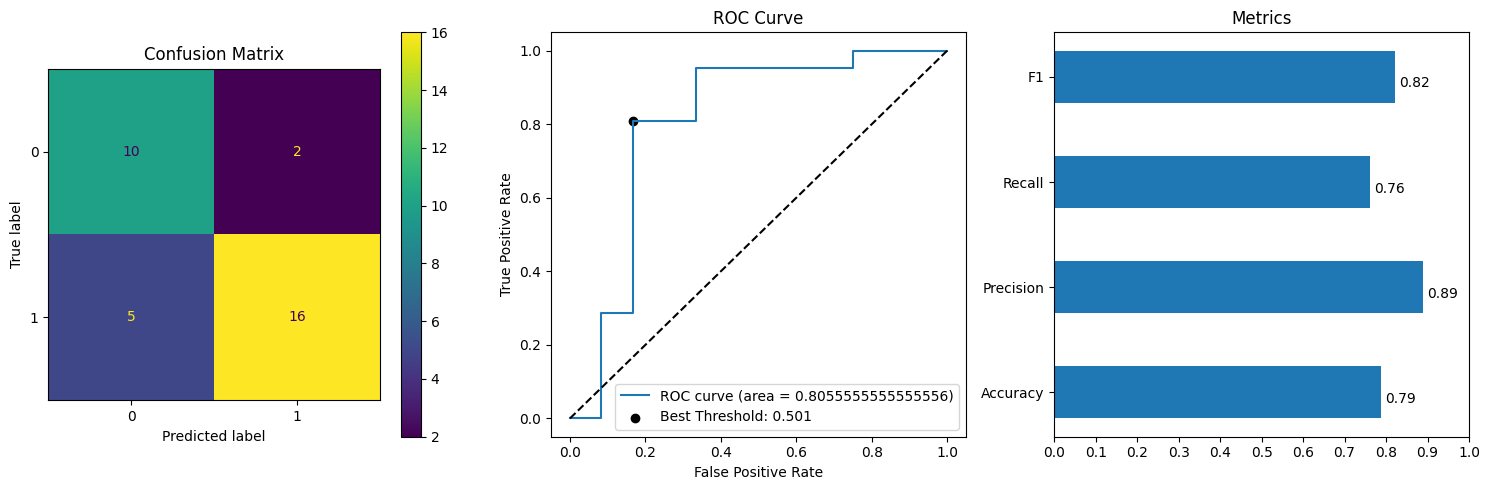

In [215]:
# Input data
receptor = 'RP'
features = pd.read_csv(repo_path / 'data/deep/features/features_1024/mean_features.csv', index_col=0)
# features = pd.read_csv(repo_path / 'data/features/pure_corrected/mean_features.csv', index_col=0)

# prepare pipeline
predictor = predictor_machine()
predictor.set_receptor(receptor, show_distribution=True)

# SVM
pred = LogisticRegression(class_weight='balanced')
parameters = {'penalty':['l2', 'l1'], 'C':[0.001, 0.01, 0.1, 1, 10], 'solver':['liblinear']}
predictor.set_classifier(pred, parameters, verbose=0)

predictor.prepare_features(features, show_info=True, scale_together=True, n_features=2, corr_threshold=0.90)
predictor.train()
predictor.compute_metrics(plot_metrics=True)
# predictor.dumb_inference()
# predictor.compute_metrics(plot_metrics=True)

### Testing using the individual radiologist features.
- Small variations around the original AUC value

In [9]:
# for rad in ['V', 'M', 'L']:
#     for time in [1,2]:
#         # get the features, remove the first column (patient ID)
#         features = pd.read_csv(repo_path / f'data/deep/features/features_1024/{rad}_{time}_features.csv', index_col=0)

#         # redefine new features and labels
#         predictor.prepare_features(features, show_info=True, scale_together=False, training=False)
#         predictor.ordered_inference()
#         predictor.compute_metrics(plot_metrics=True)

### Testing with budget

The budget testing deteriorates the performance of the model, but it is still better than the original model.

Computed prediction using budge, NO training done.


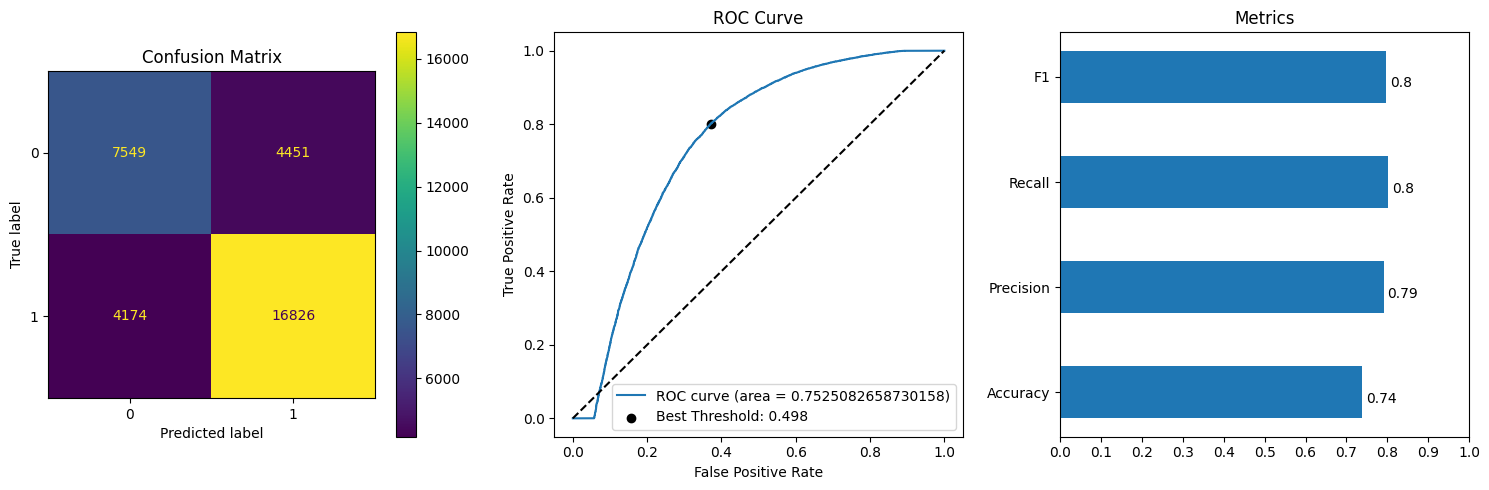

In [216]:
predictor.budget_inference()
predictor.compute_metrics(plot_metrics=True)

### Training with budget

Now, we want to see if the budget can be used to improve the performance of the model during training.

Training with budget finished!


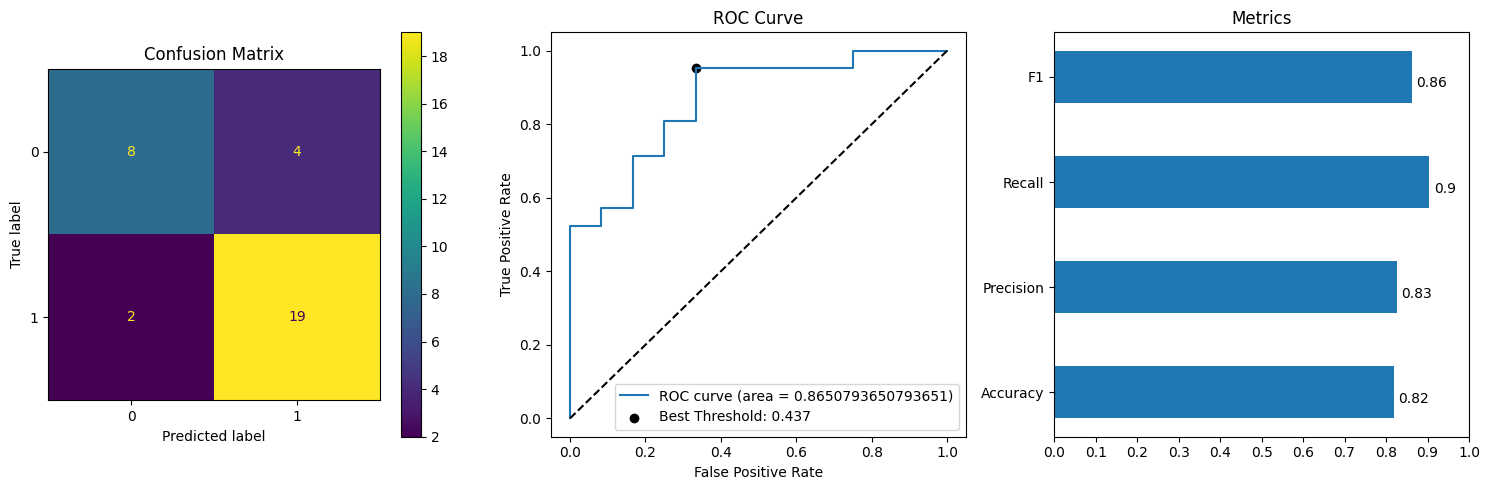

Computed prediction using budge, NO training done.


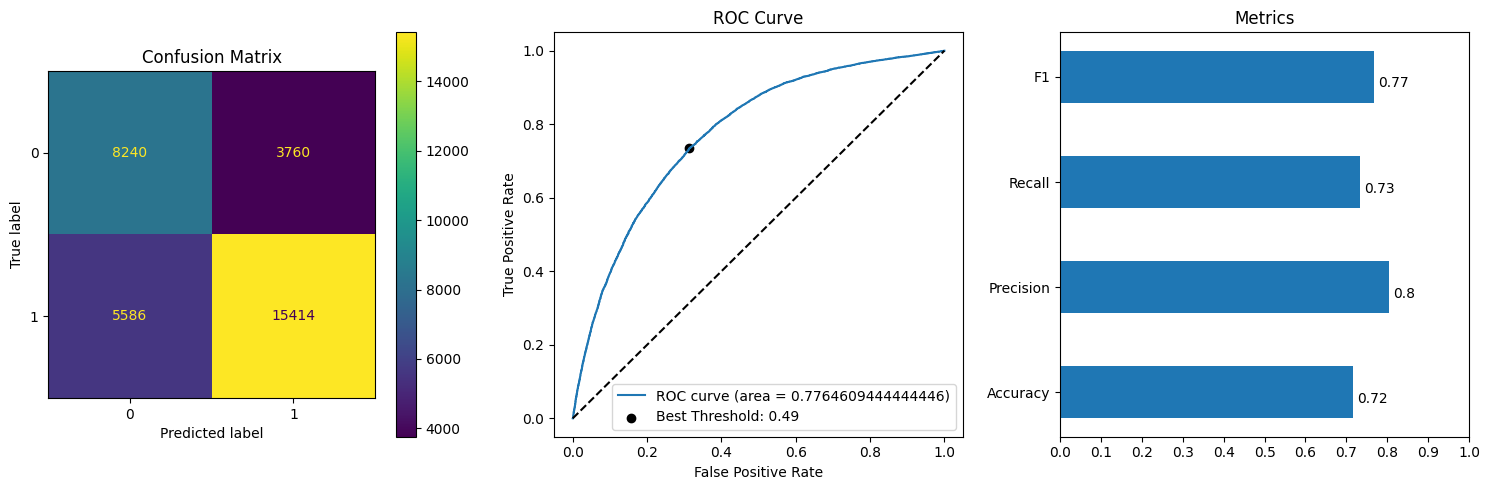

In [217]:
predictor.budget_training()
predictor.compute_metrics(plot_metrics=True)
predictor.budget_inference()
predictor.compute_metrics(plot_metrics=True)

# Full budget pipeline comparison

The positive cases of RP represent 63.6%
Original features, 101 features.
Features with high correlation: ['shape2D_MaximumDiameter', 'shape2D_MeshSurface', 'shape2D_MinorAxisLength', 'shape2D_Perimeter', 'shape2D_PixelSurface', 'firstorder_InterquartileRange', 'firstorder_Maximum', 'firstorder_MeanAbsoluteDeviation', 'firstorder_Mean', 'firstorder_Median', 'firstorder_Range', 'firstorder_RobustMeanAbsoluteDeviation', 'firstorder_RootMeanSquared', 'firstorder_TotalEnergy', 'firstorder_Uniformity', 'firstorder_Variance', 'glcm_Autocorrelation', 'glcm_ClusterProminence', 'glcm_ClusterShade', 'glcm_ClusterTendency', 'glcm_DifferenceAverage', 'glcm_DifferenceEntropy', 'glcm_DifferenceVariance', 'glcm_Id', 'glcm_Idm', 'glcm_Idn', 'glcm_Imc1', 'glcm_Imc2', 'glcm_InverseVariance', 'glcm_JointAverage', 'glcm_JointEnergy', 'glcm_JointEntropy', 'glcm_MCC', 'glcm_MaximumProbability', 'glcm_SumEntropy', 'glcm_SumSquares', 'glszm_GrayLevelNonUniformityNormalized', 'glszm_GrayLevelVariance', 'glszm_

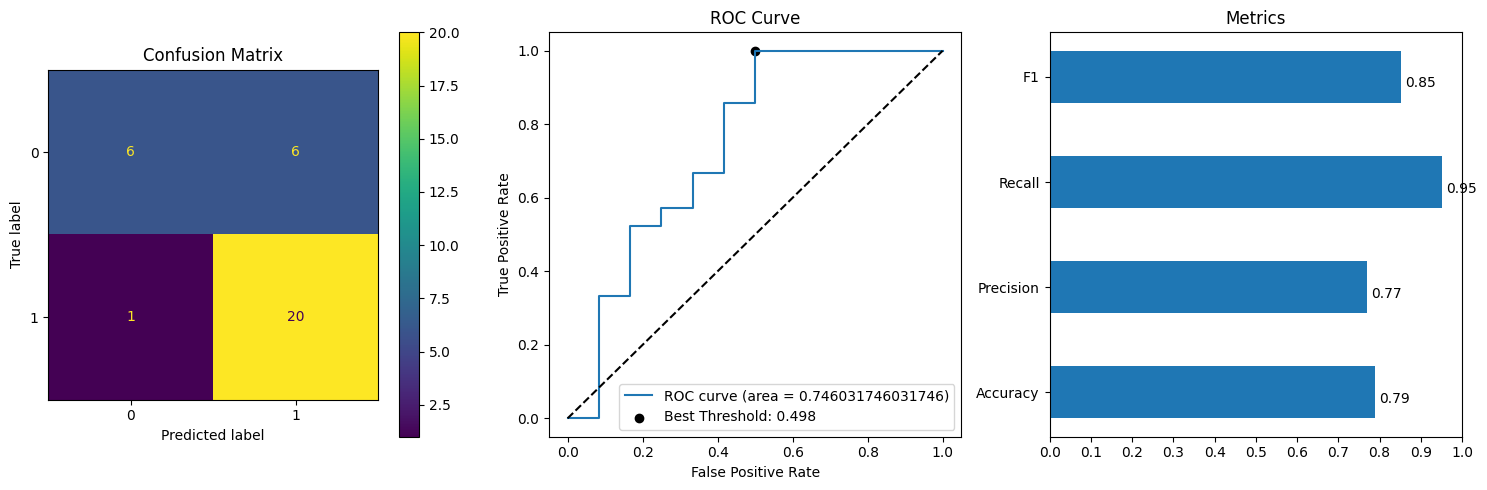

Computed prediction using budge, NO training done.


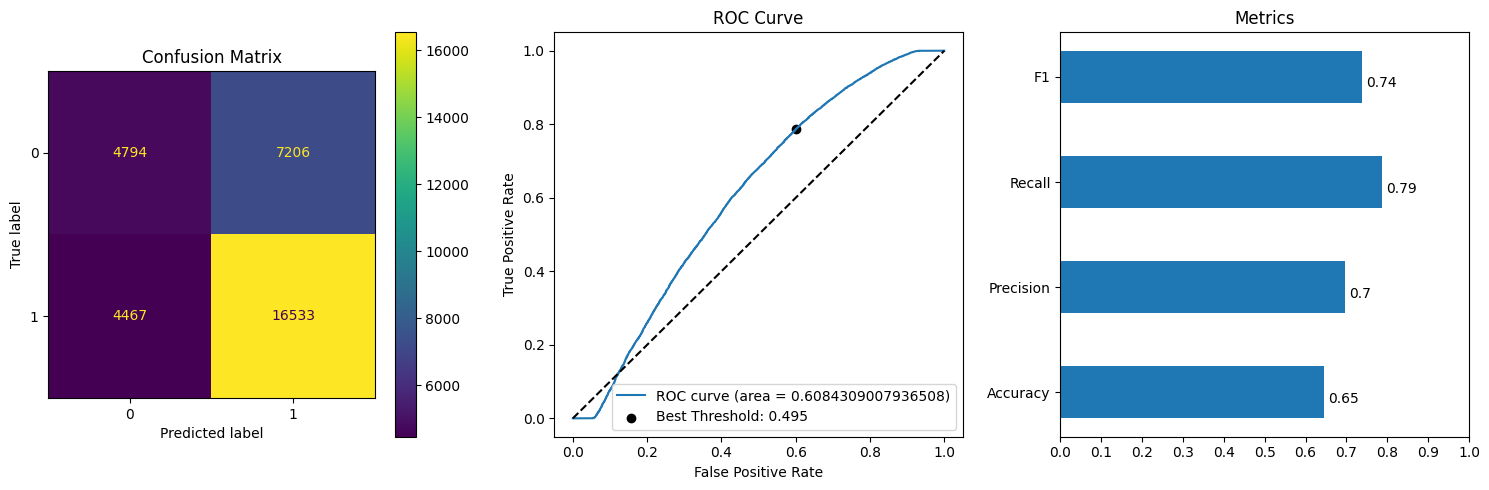

Training with budget finished!
Computed prediction using budge, NO training done.


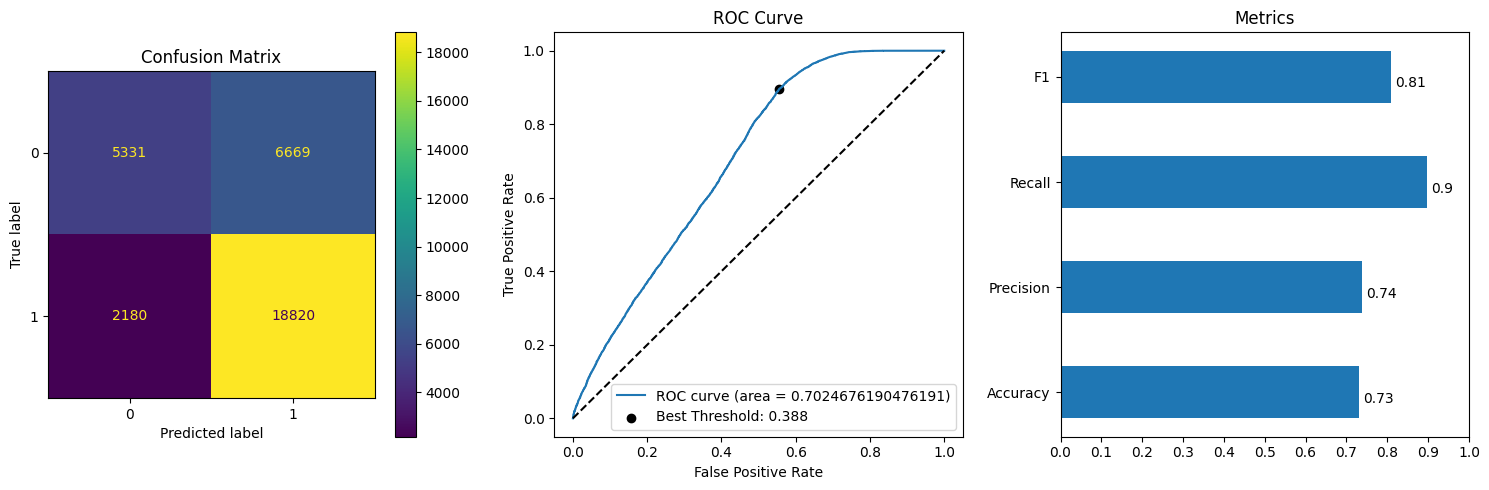

In [4]:
# Input data
receptor = 'RP'
# features = pd.read_csv(repo_path / 'data/deep/features/features_1024/mean_features.csv', index_col=0)
features = pd.read_csv(repo_path / 'data/features/pure_corrected/mean_features.csv', index_col=0)

# prepare pipeline
predictor = predictor_machine(feature_type='radiomics')
predictor.set_receptor(receptor, show_distribution=True)

# SVM
pred = LogisticRegression(class_weight='balanced')
parameters = {'penalty':['l2', 'l1'], 'C':[0.001, 0.01, 0.1, 1, 10], 'solver':['liblinear']}
predictor.set_classifier(pred, parameters, verbose=0)

predictor.prepare_features(features, show_info=True, scale_together=True, n_features=4, corr_threshold=0.90)
predictor.train()
predictor.compute_metrics(plot_metrics=True)
predictor.budget_inference()
predictor.compute_metrics(plot_metrics=True)
predictor.budget_training()
# predictor.compute_metrics(plot_metrics=True)
predictor.budget_inference()
predictor.compute_metrics(plot_metrics=True)